## CutMix, Mixup exp
- 초기 실험 중요
  - 얼마나 걸리는지.. 등..을 확인 후에, **자원을 효율적으로 사용**하기 위하여 초기 실험의 환경을 설정해야 함
  - 뭘 먼저 확인할 건지 우선 순위 설정도 해야 함
- 오버피팅 지점이 어디..? -> 각 모델의 오버피팅을 확인해야함
- 테스트 데이터를 이용해서 진짜 잘 나오는지 확인
  - 오버피팅 전 && 최적화 모델
- 중간 중간 기록하기
- Training loss와 validation accuracy 비교
- 그래프를 세로로 놓으면 에폭을 비교하기 편함

### 1. Augmentation을 적용한 데이터셋 만들기

In [1]:
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import os

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

### **Cutmix Augmentation**

In [5]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

In [6]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [7]:
# mix two labels
# def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120): # parameter undefined
def mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [8]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### **Mixup Augmentation**

In [9]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [10]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### **augmentations을 적용하는 함수**

In [11]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, additional_aug=None):
    # 코드 가독성이 떨어져서 is_train 변수 추가
    is_train = not is_test
    
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=2)

    if is_train and with_aug:
        ds = ds.map(augment)
        
    ds = ds.batch(batch_size)

    if is_train and additional_aug != None:
        assert additional_aug in {'cutmix', 'mixup'}, \
            f"Invalid additional_aug value: {additional_aug}. Must be 'cutmix' or 'mixup'."
        
        aug_methods = {
            'cutmix': cutmix,
            'mixup': mixup
        }
        
        ds = ds.map(
            aug_methods[additional_aug],
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )

    if is_train:
        ds = ds.repeat()
        ds = ds.shuffle(200)

    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [12]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [13]:
num_classes = ds_info.features["label"].num_classes

In [14]:
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, additional_aug='cutmix')
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [15]:
import matplotlib.pyplot as plt

def plt_image_from_dataset(ds):
    image_aug, label_aug = next(iter(ds))
    plt.imshow(image_aug[0])
    plt.show()
    
    print(label_aug[0])

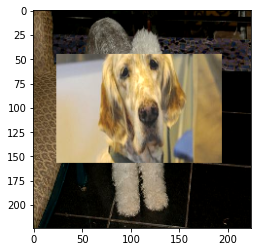

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.62053573 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.3794643  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [16]:
plt_image_from_dataset(ds_train_cutmix)

### 2. 모델 만들기

In [17]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

### 3. 모델 훈련하기
- categorical_crossentropy() 손실 함수 사용

In [19]:
EPOCH=40

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

checkpoint_path_cutmix = os.getenv('HOME')+'/aiffel/data_augmentation/checkpoint/cutmix_checkpoint.weights.h5'
model_checkpoint_cutmix = ModelCheckpoint(
    checkpoint_path_cutmix,
    save_weights_only=True, 
    monitor='val_loss',
    save_best_only=True,
    verbose=1)


history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    callbacks=[model_checkpoint_cutmix],
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/40
750/750 [==============================] - 166s 204ms/step - loss: 3.8599 - accuracy: 0.2068 - val_loss: 3.0505 - val_accuracy: 0.2506

Epoch 00001: val_loss improved from inf to 3.05048, saving model to /aiffel/aiffel/data_augmentation/checkpoint/cutmix_checkpoint.weights.h5
Epoch 2/40
750/750 [==============================] - 160s 214ms/step - loss: 3.0086 - accuracy: 0.4156 - val_loss: 1.4181 - val_accuracy: 0.6023

Epoch 00002: val_loss improved from 3.05048 to 1.41806, saving model to /aiffel/aiffel/data_augmentation/checkpoint/cutmix_checkpoint.weights.h5
Epoch 3/40
750/750 [==============================] - 160s 214ms/step - loss: 2.7143 - accuracy: 0.5042 - val_loss: 1.2903 - val_accuracy: 0.6364

Epoch 00003: val_loss improved from 1.41806 to 1.29034, saving model to /aiffel/aiffel/data_augmentation/checkpoint/cutmix_checkpoint.weights.h5
Epoch 4/40
750/750 [==============================] - 160s 213ms/step - loss: 2.5649 - accuracy: 0.5459 - val_loss: 1.2675 - val

750/750 [==============================] - 160s 214ms/step - loss: 1.4369 - accuracy: 0.8424 - val_loss: 1.4386 - val_accuracy: 0.6723

Epoch 00038: val_loss did not improve from 1.13660
Epoch 39/40
750/750 [==============================] - 174s 231ms/step - loss: 1.4104 - accuracy: 0.8468 - val_loss: 1.3522 - val_accuracy: 0.6916

Epoch 00039: val_loss did not improve from 1.13660
Epoch 40/40
750/750 [==============================] - 161s 214ms/step - loss: 1.3966 - accuracy: 0.8451 - val_loss: 1.6326 - val_accuracy: 0.6368

Epoch 00040: val_loss did not improve from 1.13660


### 4. 훈련 과정 시각화하기
- 히스토리를 그래프로 시각화

In [24]:
def visualize_history(history, title):
    plt.figure(figsize=(12, 5))

    accuray_gap = [train - val for train, val in zip(history.history['accuracy'], history.history['val_accuracy'])]
    loss_gap = [val - train for train, val in zip(history.history['loss'], history.history['val_loss'])]

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(accuray_gap, label='Accuracy Gap (Train - Val)', linestyle='dashed')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(loss_gap, label='Loss Gap (Train - Val)', linestyle='dashed')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.show()

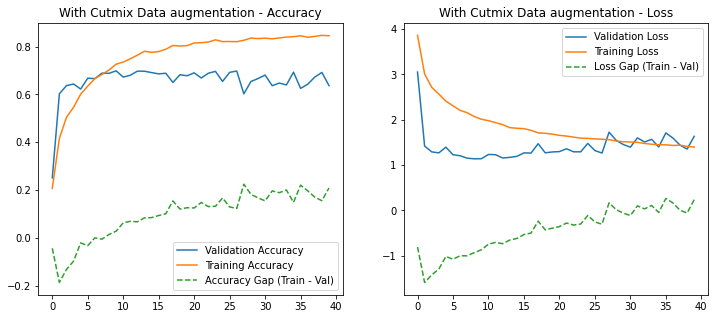

In [25]:
visualize_history(history_resnet50_cutmix, "With Cutmix Data augmentation")

In [26]:
import pandas as pd

def save_history_to_csv_path(history, csv_path):
    history_data = history.history
    df = pd.DataFrame(history_data)
    df.to_csv(csv_path, index=False)

In [23]:
history_resnet50_cutmix_csv_path = os.getenv('HOME')+'/aiffel/data_augmentation/history/history_resnet50_cutmix.csv'
save_history_to_csv_path(history_resnet50_cutmix, history_resnet50_cutmix_csv_path)

df_loaded = pd.read_csv(history_resnet50_cutmix_csv_path)
df_loaded

,loss,accuracy,val_loss,val_accuracy
0,3.859909,0.206750,3.050480,0.250583
1,3.008613,0.415583,1.418060,0.602262
2,2.714324,0.504167,1.290340,0.636427
3,2.564910,0.545917,1.267495,0.643307
4,2.408900,0.600750,1.392515,0.622085
5,2.306178,0.634833,1.226493,0.667561
6,2.206429,0.665667,1.204276,0.665695
7,2.153508,0.682917,1.150364,0.688666
8,2.069144,0.702000,1.136599,0.687966
9,2.009027,0.726333,1.138388,0.698461


### 5. Augmentation에 의한 모델 성능 비교
- No Augmentation
- 기본 Augmentation
- 기본 + CutMix 적용
- 기본 + Mixup 적용

In [31]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMAGE_SIZE=224

def predict(image_path, ds_info, model, debug=False):
    test_image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    if debug:
        plt.imshow(test_image)
        plt.show()
    
    # preprocess
    test_image = tf.image.resize(test_image, (IMAGE_SIZE, IMAGE_SIZE))
    test_image = tf.cast(test_image, tf.float32) / 255.
    if debug:
        plt.imshow(test_image)
        plt.show()
    
    # reshape to adjust the batch dimension
    test_image = tf.expand_dims(test_image, axis=0)
    
    # predict
    output = model.predict(test_image)
    
    label_index = np.argmax(output)
    label = ds_info.features['label'].int2str(label_index)

    return label_index, label

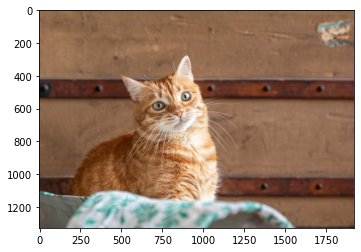

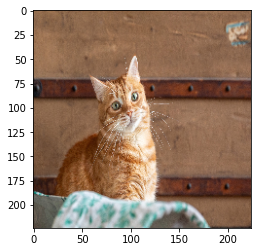

(33, 'n02093991-irish_terrier')

In [32]:
cat_path = os.getenv('HOME')+"/aiffel/data_augmentation/data/cat.jpg"
cat_label_idx, cat_label = predict(cat_path, ds_info, cutmix_resnet50, debug=True)
cat_label_idx, cat_label

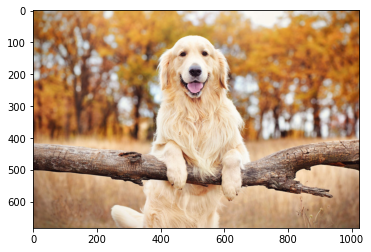

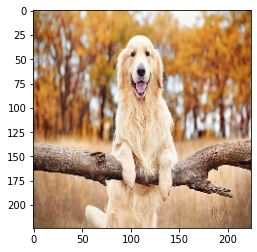

(49, 'n02097474-tibetan_terrier')

In [33]:
golden_path = os.getenv('HOME')+"/aiffel/data_augmentation/data/Golden-Retriever.jpg"
golden_label_idx, golden_label = predict(golden_path, ds_info, cutmix_resnet50, debug=True)
golden_label_idx, golden_label

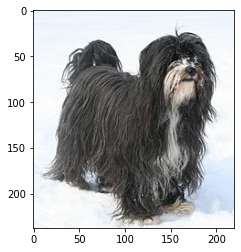

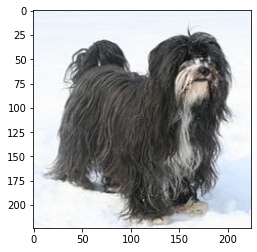

(100, 'n02110627-affenpinscher')

In [35]:
tibetan_terrier_path = os.getenv('HOME')+"/aiffel/data_augmentation/data/tibetan_terrier.jpg"
tibetan_terrier_label_idx, tibetan_terrier_label = predict(tibetan_terrier_path, ds_info, cutmix_resnet50, debug=True)
tibetan_terrier_label_idx, tibetan_terrier_label